In [24]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%run MEAN_AND_STANDARD_DEVIATION_OF_IMAGE_SET.ipynb


['cats', 'dogs']
tensor([0.4883, 0.4551, 0.4174])

tensor([0.2259, 0.2209, 0.2214])


In [25]:
training_dataset_path = r"C:\Users\LENOVO\OneDrive\Desktop\IMAGE CLASSIFICATION PROJECT\test_set\training_set"
test_dataset_path = r"C:\Users\LENOVO\OneDrive\Desktop\IMAGE CLASSIFICATION PROJECT\test_set\test_set"

IMAGE DATASET PREPRATION IN PYTORCH(DATALOADERS AND TRANSFORMS)

In [26]:
# mean = [0.4867, 0.4527, 0.4135]
# std = [0.2263, 0.2206, 0.2209]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [27]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)


In [28]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ',labels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1610065..2.6315455].


labels:  tensor([0, 0, 0, 0, 0, 0])


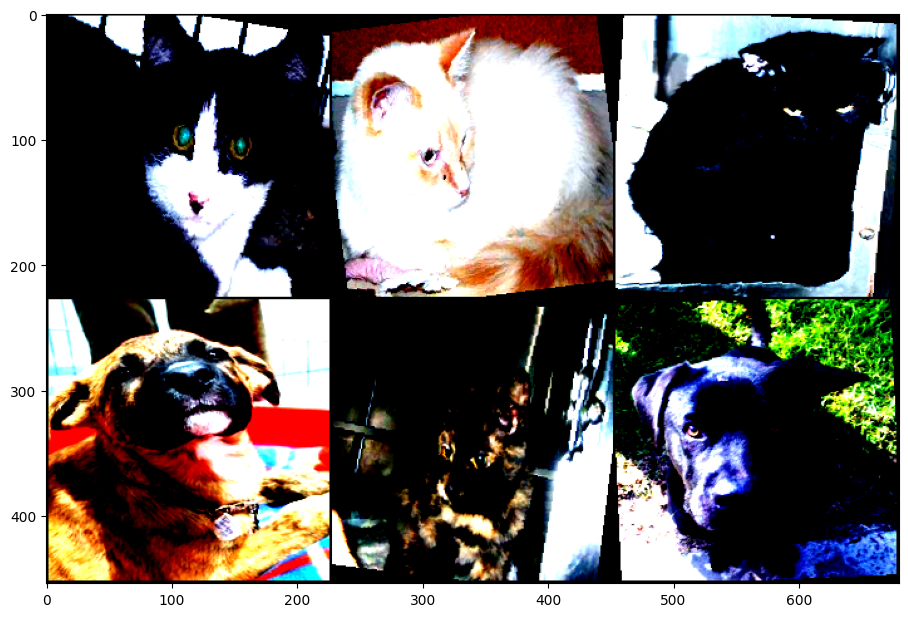

In [29]:
show_transformed_images(train_dataset)

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

TRAIN NEURAL NETWORKS

In [31]:
torch.cuda.is_available()

False

In [32]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)  


In [33]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device =  set_device()
    best_acc = 0
    for epoch in range(n_epochs):
        print("Epoch number  %d " % (epoch+1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        
        epoch_loss  = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct/total

        print("    -Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))

    test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

    if(test_dataset_acc > best_acc):
        best_acc =  test_dataset_acc
        save_checkpoint(model, epoch, optimizer, best_acc)

    print("Finished")
    return model


In [34]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    epoch_acc = 100.00 * predicted_correctly_on_epoch/total
    print("     -Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))

    return epoch_acc

In [35]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch':epoch + 1,
        'model':model.state_dict(),
        'best accuracy':best_acc,
        'optimizer':optimizer.state_dict(),
        'comments':'very cool model!',
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [36]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

Epoch number  1 
    -Training dataset. Got 7995 out of 8005 images correctly (99.875%). Epoch loss: 0.003
Epoch number  2 
    -Training dataset. Got 8005 out of 8005 images correctly (100.000%). Epoch loss: 0.000
Epoch number  3 
    -Training dataset. Got 8005 out of 8005 images correctly (100.000%). Epoch loss: 0.000
Epoch number  4 
    -Training dataset. Got 8005 out of 8005 images correctly (100.000%). Epoch loss: 0.000
Epoch number  5 


KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['comments'])
print(checkpoint['best accuracy'])

In [ ]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])
torch.save(resnet18_model, best_model.pth)

In [ ]:
import PIL.Image as Image

In [ ]:
classes = [
    "Cat",
    "Dog",
]

In [ ]:
model = torch.load('best_model.pth')

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [ ]:
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)

    output = model(image)
    _,predicted = torch.max(output.data, 1)

    print(classes[predicted.item()])

In [ ]:
classify(model, image_transforms, r"C:\Users\LENOVO\OneDrive\Desktop\IMAGE CLASSIFICATION PROJECT\test_set\test_set\cats\cat.4001.jpg",classes)